## For Hubble Deep Field North (Default)

σ_NMAD = 0.0389, Outlier fraction = 7.89%


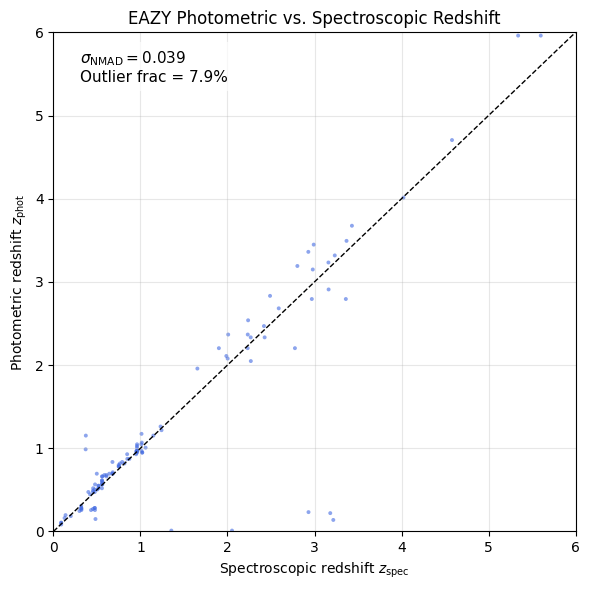

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table


def plot_zphot_zspec(zout_path, save_as='zphot_zspec.png', zmax=6, outlier_thresh=0.15):
    """
    Create a z_phot vs z_spec diagnostic plot similar to threedhst.eazyPy.zPhot_zSpec,
    including σ_NMAD and outlier fraction.

    Parameters
    ----------
    zout_path : str
        Path to the EAZY output file (photz.zout).
    save_as : str, optional
        Output filename for the plot (default: 'zphot_zspec.png').
    zmax : float, optional
        Maximum redshift for axes (default: 6).
    outlier_thresh : float, optional
        |Δz|/(1+z_spec) threshold for outliers (default: 0.15).
    """
    # --- Load EAZY output
    zout = Table.read(zout_path, format='ascii')

    # --- Identify columns automatically
    colnames = [c.lower() for c in zout.colnames]
    if 'z_spec' in colnames:
        zspec_col = zout.colnames[colnames.index('z_spec')]
    elif 'zspec' in colnames:
        zspec_col = zout.colnames[colnames.index('zspec')]
    else:
        raise ValueError("No spectroscopic redshift column found in .zout file.")

    if 'z_a' in colnames:
        zphot_col = zout.colnames[colnames.index('z_a')]
    elif 'z_phot' in colnames:
        zphot_col = zout.colnames[colnames.index('z_phot')]
    else:
        raise ValueError("No photometric redshift column (z_a / z_phot) found in .zout file.")

    # --- Extract arrays and clean NaNs
    zspec = np.array(zout[zspec_col])
    zphot = np.array(zout[zphot_col])
    mask = np.isfinite(zspec) & np.isfinite(zphot)
    zspec, zphot = zspec[mask], zphot[mask]

    # --- Compute scatter metrics
    dz = (zphot - zspec) / (1 + zspec)
    dz = dz[np.isfinite(dz)]
    sigma_nmad = 1.48 * np.median(np.abs(dz - np.median(dz)))
    outlier_frac = np.mean(np.abs(dz) > outlier_thresh)

    # --- Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(zspec, zphot, s=8, alpha=0.6, color='royalblue', edgecolor='none', label='Data')
    plt.plot([0, zmax], [0, zmax], 'k--', lw=1, label='1:1')
    plt.xlabel(r'Spectroscopic redshift $z_{\rm spec}$')
    plt.ylabel(r'Photometric redshift $z_{\rm phot}$')
    plt.xlim(0, zmax)
    plt.ylim(0, zmax)
    plt.grid(alpha=0.3)

    # --- Annotate performance
    txt = (rf"$\sigma_{{\rm NMAD}} = {sigma_nmad:.3f}$" + "\n" +
           rf"Outlier frac = {outlier_frac*100:.1f}%")
    plt.text(0.05*zmax, 0.9*zmax, txt, fontsize=11, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    plt.title('EAZY Photometric vs. Spectroscopic Redshift')
    plt.tight_layout()
    # plt.savefig(save_as, dpi=150)
    # plt.close()

    # print(f"✅ Plot saved to {save_as}")
    print(f"σ_NMAD = {sigma_nmad:.4f}, Outlier fraction = {outlier_frac*100:.2f}%")


plot_zphot_zspec('../outputs/OUTPUT_HDF-N/photz.zout', save_as='zphot_zspec.png', zmax=6)

## For JWST GOODS-N

In [67]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import astropy.io.fits as pyfits
import grizli
import grizli.catalog
from grizli import utils

import eazy

print(f'grizli version: {grizli.__version__}')
print(f'eazy-py version: {eazy.__version__}')

grizli version: 1.13.2
eazy-py version: 0.8.5


In [61]:
field = 'gds-grizli-v7.0'

url_path = 'https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7'

phot = utils.read_catalog(f'{url_path}/{field}_phot.fits')
phot

id,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2_image,y2_image,xy_image,errx2,erry2,errxy,a_image,b_image,theta_image,cxx_image,cyy_image,cxy_image,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag,x_image,y_image,number,ra,dec,x_world,y_world,flux_iso,fluxerr_iso,area_iso,mag_iso,kron_radius,kron_rcirc,flux_auto,fluxerr_auto,bkg_auto,flag_auto,area_auto,flux_radius_flag,flux_radius_20,flux_radius,flux_radius_90,tot_corr,mag_auto,magerr_auto,flux_aper_0,fluxerr_aper_0,flag_aper_0,bkg_aper_0,mask_aper_0,flux_aper_1,fluxerr_aper_1,flag_aper_1,bkg_aper_1,mask_aper_1,flux_aper_2,fluxerr_aper_2,flag_aper_2,bkg_aper_2,mask_aper_2,flux_aper_3,fluxerr_aper_3,flag_aper_3,bkg_aper_3,mask_aper_3,clearp-f430m_flux_aper_0,clearp-f430m_fluxerr_aper_0,clearp-f430m_flag_aper_0,clearp-f430m_bkg_aper_0,clearp-f430m_mask_aper_0,clearp-f430m_flux_aper_1,clearp-f430m_fluxerr_aper_1,clearp-f430m_flag_aper_1,clearp-f430m_bkg_aper_1,clearp-f430m_mask_aper_1,clearp-f430m_flux_aper_2,clearp-f430m_fluxerr_aper_2,clearp-f430m_flag_aper_2,clearp-f430m_bkg_aper_2,clearp-f430m_mask_aper_2,clearp-f430m_flux_aper_3,clearp-f430m_fluxerr_aper_3,clearp-f430m_flag_aper_3,clearp-f430m_bkg_aper_3,clearp-f430m_mask_aper_3,clearp-f430m_tot_corr,clearp-f480m_flux_aper_0,clearp-f480m_fluxerr_aper_0,clearp-f480m_flag_aper_0,clearp-f480m_bkg_aper_0,clearp-f480m_mask_aper_0,clearp-f480m_flux_aper_1,clearp-f480m_fluxerr_aper_1,clearp-f480m_flag_aper_1,clearp-f480m_bkg_aper_1,clearp-f480m_mask_aper_1,clearp-f480m_flux_aper_2,clearp-f480m_fluxerr_aper_2,clearp-f480m_flag_aper_2,clearp-f480m_bkg_aper_2,clearp-f480m_mask_aper_2,clearp-f480m_flux_aper_3,clearp-f480m_fluxerr_aper_3,clearp-f480m_flag_aper_3,clearp-f480m_bkg_aper_3,clearp-f480m_mask_aper_3,clearp-f480m_tot_corr,f090w-clear_flux_aper_0,f090w-clear_fluxerr_aper_0,f090w-clear_flag_aper_0,f090w-clear_bkg_aper_0,f090w-clear_mask_aper_0,f090w-clear_flux_aper_1,f090w-clear_fluxerr_aper_1,f090w-clear_flag_aper_1,f090w-clear_bkg_aper_1,f090w-clear_mask_aper_1,f090w-clear_flux_aper_2,f090w-clear_fluxerr_aper_2,f090w-clear_flag_aper_2,f090w-clear_bkg_aper_2,f090w-clear_mask_aper_2,f090w-clear_flux_aper_3,f090w-clear_fluxerr_aper_3,f090w-clear_flag_aper_3,f090w-clear_bkg_aper_3,f090w-clear_mask_aper_3,f090w-clear_tot_corr,f105w_flux_aper_0,f105w_fluxerr_aper_0,f105w_flag_aper_0,f105w_bkg_aper_0,f105w_mask_aper_0,f105w_flux_aper_1,f105w_fluxerr_aper_1,f105w_flag_aper_1,f105w_bkg_aper_1,f105w_mask_aper_1,f105w_flux_aper_2,f105w_fluxerr_aper_2,f105w_flag_aper_2,f105w_bkg_aper_2,f105w_mask_aper_2,f105w_flux_aper_3,f105w_fluxerr_aper_3,f105w_flag_aper_3,f105w_bkg_aper_3,f105w_mask_aper_3,f105w_tot_corr,f110w_flux_aper_0,f110w_fluxerr_aper_0,f110w_flag_aper_0,f110w_bkg_aper_0,f110w_mask_aper_0,f110w_flux_aper_1,f110w_fluxerr_aper_1,f110w_flag_aper_1,f110w_bkg_aper_1,f110w_mask_aper_1,f110w_flux_aper_2,f110w_fluxerr_aper_2,f110w_flag_aper_2,f110w_bkg_aper_2,f110w_mask_aper_2,f110w_flux_aper_3,f110w_fluxerr_aper_3,f110w_flag_aper_3,f110w_bkg_aper_3,f110w_mask_aper_3,f110w_tot_corr,f115w-clear_flux_aper_0,f115w-clear_fluxerr_aper_0,f115w-clear_flag_aper_0,f115w-clear_bkg_aper_0,f115w-clear_mask_aper_0,f115w-clear_flux_aper_1,f115w-clear_fluxerr_aper_1,f115w-clear_flag_aper_1,f115w-clear_bkg_aper_1,f115w-clear_mask_aper_1,f115w-clear_flux_aper_2,f115w-clear_fluxerr_aper_2,f115w-clear_flag_aper_2,f115w-clear_bkg_aper_2,f115w-clear_mask_aper_2,f115w-clear_flux_aper_3,f115w-clear_fluxerr_aper_3,f115w-clear_flag_aper_3,f115w-clear_bkg_aper_3,f115w-clear_mask_aper_3,f115w-clear_tot_corr,f115wn-clear_flux_aper_0,f115wn-clear_fluxerr_aper_0,f115wn-clear_flag_aper_0,f115wn-clear_bkg_aper_0,f115wn-clear_mask_aper_0,f115wn-clear_flux_aper_1,f115wn-clear_fluxerr_aper_1,f115wn-clear_flag_aper_1,f115wn-clear_bkg_aper_1,f115wn-clear_mask_aper_1,f115wn-clear_flux_aper_2,f115wn-clear_fluxerr_aper_2,f115wn-clear_flag_aper_2,f115wn-clear_bkg_aper_2,f115wn-clear_mask_aper_2,f115wn-clear_flux_aper_3,f115wn-clear_fluxerr_aper_3,f115wn-clear_flag_aper_3,

In [105]:
for k in phot.colnames:
    if k.endswith('_flux_aper_1'):
        print(k)

clearp-f430m_flux_aper_1
clearp-f480m_flux_aper_1
f090w-clear_flux_aper_1
f105w_flux_aper_1
f110w_flux_aper_1
f115w-clear_flux_aper_1
f115wn-clear_flux_aper_1
f125w_flux_aper_1
f140w_flux_aper_1
f150w-clear_flux_aper_1
f150wn-clear_flux_aper_1
f160w_flux_aper_1
f182m-clear_flux_aper_1
f200w-clear_flux_aper_1
f200wn-clear_flux_aper_1
f210m-clear_flux_aper_1
f277w-clear_flux_aper_1
f335m-clear_flux_aper_1
f350lpu_flux_aper_1
f356w-clear_flux_aper_1
f410m-clear_flux_aper_1
f430m-clear_flux_aper_1
f435w_flux_aper_1
f444w-clear_flux_aper_1
f460m-clear_flux_aper_1
f475w_flux_aper_1
f480m-clear_flux_aper_1
f606w_flux_aper_1
f606wu_flux_aper_1
f775w_flux_aper_1
f814w_flux_aper_1
f814wu_flux_aper_1
f850lp_flux_aper_1
f850lpu_flux_aper_1


In [90]:
count = 0
for k in phot.colnames:
    if not phot[k].mask.any():
        if k.endswith('_flux_aper_1'):
            count += 1
            print(f"{count:>2} {k.split('_flux')[0]}")

AttributeError: 'Column' object has no attribute 'mask'

## For JWST GOODS-S

## For JWST CEERS